**Content provided under a Creative Commons Attribution license, CC-BY 4.0. Code under Apache-2.0 License. (c) 2019 Liangchen Luo.**

**Last built on February 19, 2019.**

This is one of the notebooks for the [demos of AdaBound](https://github.com/Luolc/AdaBound/tree/master/demos), for visualizing the performance of AdaBound and its counterparts using Jupyter Notebook. 
AdaBound was proposed in the paper [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://openreview.net/forum?id=Bkg3g2R9FX) in *Proceedings of ICLR 2019*.
You can view the [GitHub page of AdaBound](https://github.com/Luolc/AdaBound) to learn about the basic usage of AdaBound in popular deep learning frameworks.

You can read and follow along this notebook online, or clone and run on your local.

# Empirical Study on CIFAR-10

Let's play with the CIFAR-10 ([Krizhevsky & Hinton, 2009](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)) image classification task.
We will train two benchmark models: ResNet ([He et al., 2016](https://arxiv.org/abs/1512.03385)) and DenseNet ([Huang et al., 2017](https://arxiv.org/abs/1608.06993)) with AdaBound/AMSBound and other baseline methods: SGD, AdaGrad, Adam, and AMSGrad.

We've already provided the code for training and evaluation [here](https://github.com/Luolc/AdaBound/tree/master/demos/cifar10).
We employ the fixed budget of 200 epochs and reduce the learning rates by 10 after 150 epochs.
The online version of this notebook will use the data points of pretrained models, which were produced by AdaBound/AMSBound with default settings and baseline optimizers with their best hyperparameters.
To run the experiments by yourself, please follow the [instructions](https://github.com/Luolc/AdaBound/tree/master/demos/cifar10) and change the plotting parameter in this notebook correspodingly.

In [1]:
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np

LABELS = ['SGD', 'AdaGrad', 'Adam', 'AMSGrad', 'AdaBound', 'AMSBound']

In [2]:
def get_folder_path(use_pretrained=True):
    path = 'curve'
    if use_pretrained:
        path = os.path.join(path, 'pretrained')
    return path

In [3]:
def get_curve_data(use_pretrained=True, model='ResNet'):
    folder_path = get_folder_path(use_pretrained)
    filenames = os.listdir(folder_path)
    paths = [os.path.join(folder_path, name) for name in filenames if name.startswith(model.lower())]
    keys = [name.split('-')[1] for name in filenames]
    return {key: torch.load(fp) for key, fp in zip(keys, paths)}

In [4]:
def plot(use_pretrained=True, model='ResNet', optimizers=None, curve_type='train'):
    assert model in ['ResNet', 'DenseNet'], 'Invalid model name: {}'.format(model)
    assert curve_type in ['train', 'test'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    curve_data = get_curve_data(use_pretrained, model=model)
    
    plt.figure()
    plt.title('{} Accuracy for {} on CIFAR-10'.format(curve_type.capitalize(), model))
    plt.xlabel('Epoch')
    plt.ylabel('{} Accuracy %'.format(curve_type.capitalize()))
    plt.ylim(80, 101 if curve_type == 'train' else 96)
    
    for optim in optimizers:
        linestyle = '--' if 'Bound' in optim else '-'
        accuracies = np.array(curve_data[optim.lower()]['{}_acc'.format(curve_type)])
        plt.plot(accuracies, label=optim, ls=linestyle)
        
    plt.grid(ls='--')
    plt.legend()
    plt.show()

The above function is for plotting the learning curves. To use your own data points, set `use_pretrained` as `False`.

## ResNet

First, let's see the results with ResNet-34.

<IPython.core.display.Javascript object>


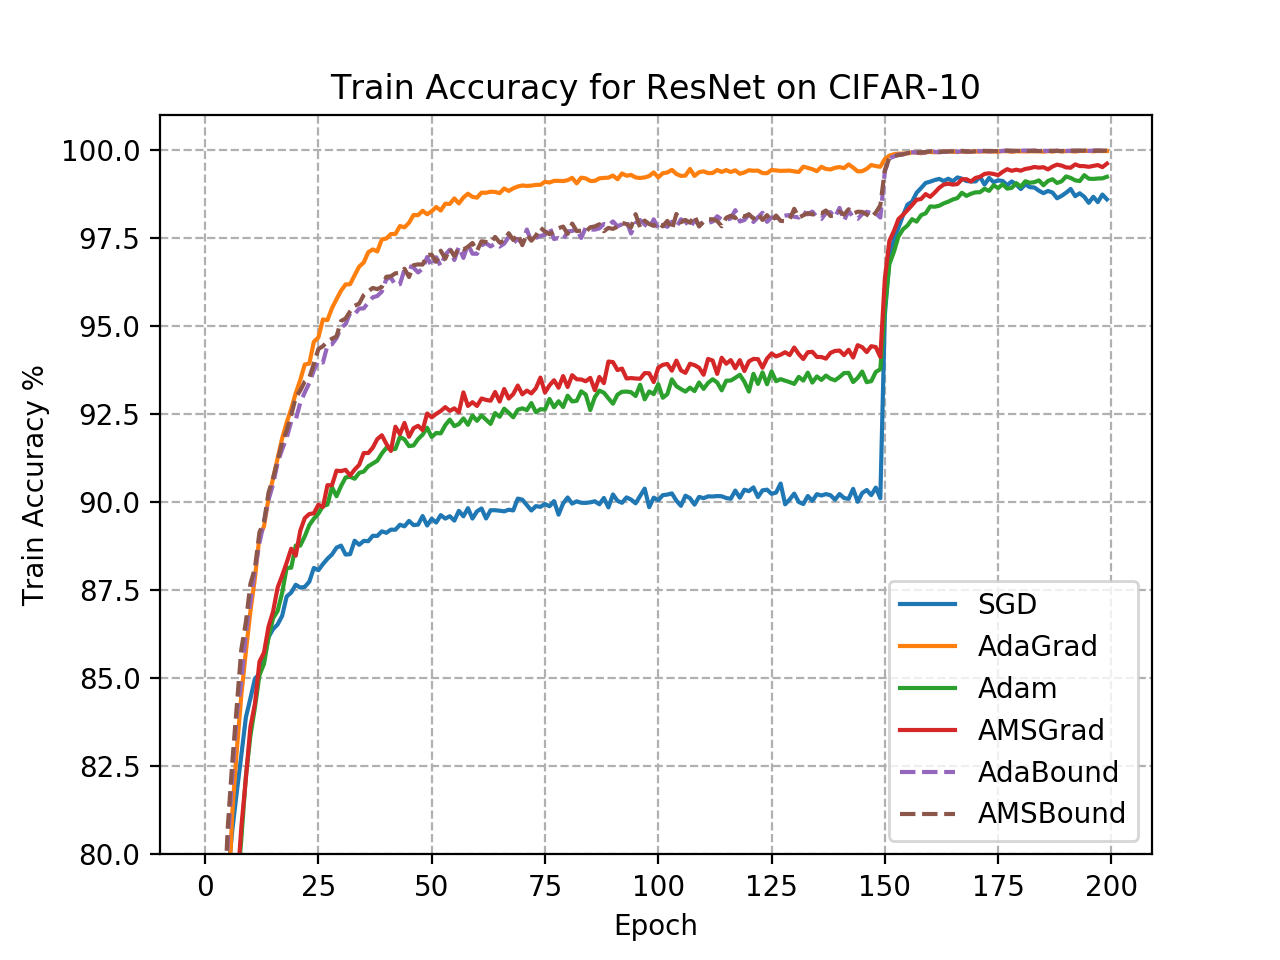

<IPython.core.display.Javascript object>


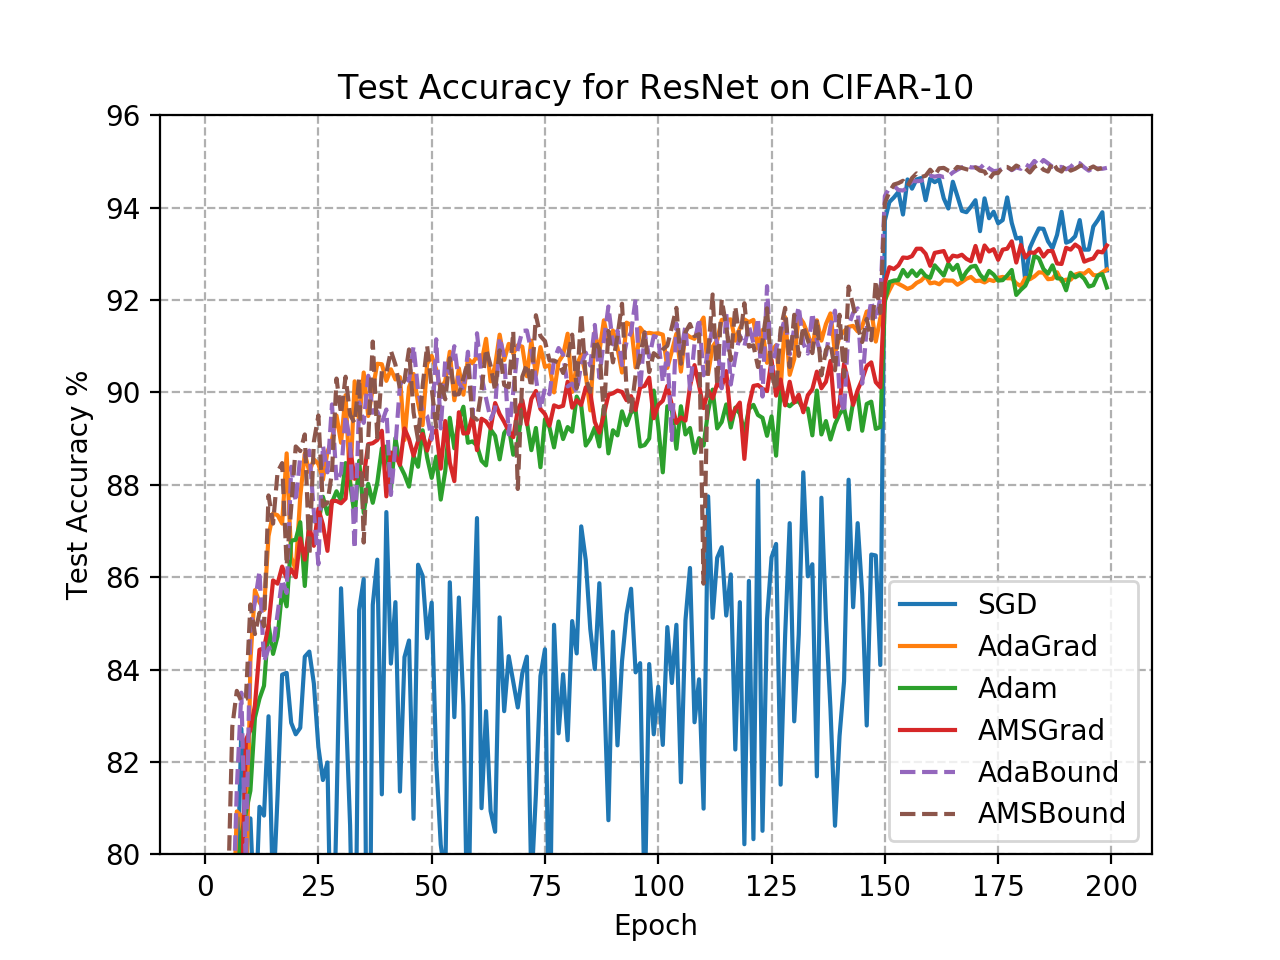

In [5]:
plot(use_pretrained=True, model='ResNet', optimizers=LABELS, curve_type='train')
plot(use_pretrained=True, model='ResNet', optimizers=LABELS, curve_type='test')

We can see that adaptive methods such as AdaGrad, Adam and AMSGrad appear to perform better than the non-adaptive ones early in training. 
But by epoch 150 when the learning rates are decayed, SGD begins to outperform those adaptive methods. 
As for our methods, AdaBound and AMSBound, they converge as fast as adaptive ones and achieve a higher accuracy than SGD on the test set at the end of training. 
In addition, compared with their prototypes, their performances on the unseen data (test set) are enhanced evidently.

You may observe a slight decline of the test accuracy with SGD.
Since the decline also occurs in training, this may not be caused by overfitting but some other reasons.
This behavior indicates the unstable performance of SGD to some extent, which is similar to the observation reported in [He et al. (2016)]((https://arxiv.org/abs/1512.03385)).